# Demo for the DoWhy causal API
We show a simple example of adding a causal extension to any dataframe. 

In [1]:
import dowhy.datasets
import dowhy.api

import numpy as np
import pandas as pd

from statsmodels.api import OLS

In [2]:
data = dowhy.datasets.linear_dataset(beta=5,
        num_common_causes=1,
        num_instruments = 0,
        num_samples=1000,
        treatment_is_binary=True)
df = data['df']
df['y'] = df['y'] + np.random.normal(size=len(df)) # Adding noise to data. Without noise, the variance in Y|X, Z is zero, and mcmc fails.
#data['dot_graph'] = 'digraph { v ->y;X0-> v;X0-> y;}'

treatment= data["treatment_name"][0]
outcome = data["outcome_name"][0]
common_cause = data["common_causes_names"][0]
df

,W0,v0,y
0,-0.475540,False,-0.430029
1,0.274892,True,3.120211
2,-0.729099,False,0.783892
3,-0.980458,False,-2.095295
4,-0.869158,False,0.179228
...,...,...,...
995,-0.057425,False,-1.512903
996,-0.000934,True,3.680080
997,0.961657,True,7.329537
998,-0.139440,False,0.104805


<AxesSubplot: xlabel='v0'>

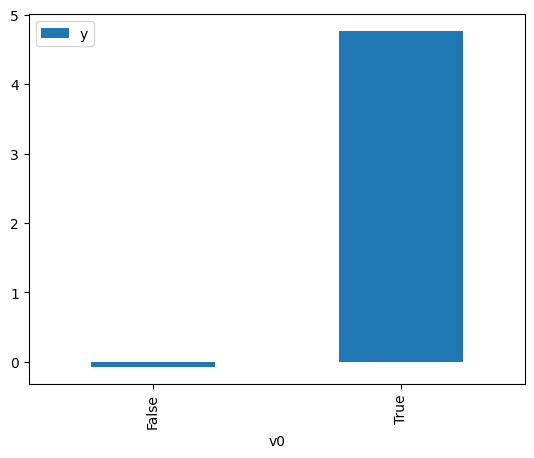

In [3]:
# data['df'] is just a regular pandas.DataFrame
df.causal.do(x=treatment,
                     variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'},
                     outcome=outcome,
                     common_causes=[common_cause],
                     proceed_when_unidentifiable=True).groupby(treatment).mean().plot(y=outcome, kind='bar')

<AxesSubplot: xlabel='v0'>

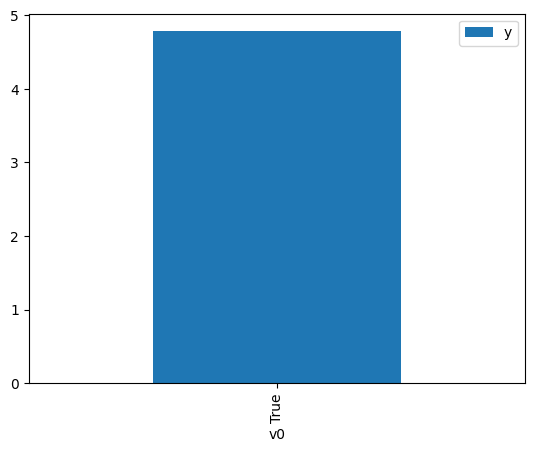

In [4]:
df.causal.do(x={treatment: 1}, 
              variable_types={treatment:'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome,
              method='weighting', 
              common_causes=[common_cause],
              proceed_when_unidentifiable=True).groupby(treatment).mean().plot(y=outcome, kind='bar')

In [5]:
cdf_1 = df.causal.do(x={treatment: 1}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              dot_graph=data['dot_graph'],
              proceed_when_unidentifiable=True)

cdf_0 = df.causal.do(x={treatment: 0}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              dot_graph=data['dot_graph'],
              proceed_when_unidentifiable=True)


In [6]:
cdf_0

,W0,v0,y,propensity_score,weight
0,0.083333,False,0.099677,0.461673,2.166036
1,-0.296947,False,-1.194076,0.683077,1.463964
2,-0.870522,False,-1.576862,0.896408,1.115564
3,-0.489989,False,2.636055,0.774825,1.290614
4,-0.235192,False,-0.481885,0.649830,1.538864
...,...,...,...,...,...
995,-0.343122,False,-0.645327,0.706790,1.414846
996,-1.632213,False,0.761509,0.982081,1.018246
997,-1.738621,False,0.460024,0.986097,1.014099
998,-0.139440,False,0.104805,0.595379,1.679602


In [7]:
cdf_1

,W0,v0,y,propensity_score,weight
0,-0.500468,True,4.754557,0.220776,4.529487
1,-2.698252,True,4.668271,0.001376,726.739363
2,-2.698252,True,4.668271,0.001376,726.739363
3,-1.073412,True,3.503218,0.066013,15.148469
4,0.793381,True,5.836313,0.866957,1.153460
...,...,...,...,...,...
995,-0.500468,True,4.754557,0.220776,4.529487
996,-1.364857,True,5.646277,0.033703,29.670959
997,-0.761892,True,4.975959,0.130712,7.650423
998,-0.806989,True,6.438569,0.118787,8.418424


## Comparing the estimate to Linear Regression
First, estimating the effect using the causal data frame, and the 95% confidence interval.

In [8]:
(cdf_1['y'] - cdf_0['y']).mean()

In [9]:
1.96*(cdf_1['y'] - cdf_0['y']).std() / np.sqrt(len(df))

Comparing to the estimate from OLS.

In [10]:
model = OLS(np.asarray(df[outcome]), np.asarray(df[[common_cause, treatment]], dtype=np.float64))
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.890
Model:                            OLS   Adj. R-squared (uncentered):              0.890
Method:                 Least Squares   F-statistic:                              4043.
Date:                Fri, 09 Dec 2022   Prob (F-statistic):                        0.00
Time:                        13:24:21   Log-Likelihood:                         -1455.9
No. Observations:                1000   AIC:                                      2916.
Df Residuals:                     998   BIC:                                      2926.
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.2168      0.030      7.263      0.000       0.158       0.275
x2             5.0476      0.058     86.385      0.000       4.933       5.162
==============================================================================
Omnibus:                        1.346   Durbin-Watson:                   2.012
Prob(Omnibus):                  0.510   Jarque-Bera (JB):                1.386
Skew:                           0.088   Prob(JB):                        0.500
Kurtosis:                       2.951   Cond. No.                         2.02
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""